In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [ ]:
import htmd

In [6]:
basedir = '/sc/orga/projects/filizm02a/work/Abhijeet/' + \
   'TRV_MOR_ACEMD/analysis_extended_abhijeet/mor/saved_metric_objects/'

### Read the features used to fit the MSM

In [7]:
## load the cv values (NPxxY RMSD and TM3-TM6 distance)
## htmd metric data object also contains the dtrajs, the cluster centers
data_dist_rmsd = htmd.MetricData()
data_dist_rmsd.load(basedir + 'reaction_cords/data_dist_rmsd')
dtrajs = data_dist_rmsd.St

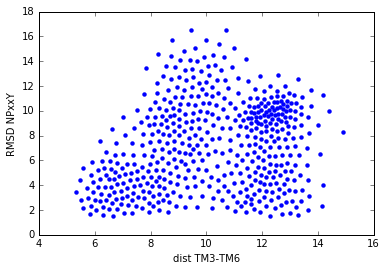

In [27]:
## centers of microstates
centers=data_dist_rmsd.Centers
scale = np.array([1,3])
scenters = centers*scale
plt.scatter(scenters[:,0],scenters[:,1],linewidths=0)
plt.xlabel('dist TM3-TM6')
plt.ylabel('RMSD NPxxY')
plt.show()

In [10]:
## calculate the distance between microstate-center clusters
## (we apply no scale between the two directions)
dist = scipy.spatial.distance.squareform(
    scipy.spatial.distance.pdist(scenters))

### Read the features used to to ticas (mindist protein-protein and protein-ligand)

In [11]:
## features (receptor-ligand, receptor-receptor contacts)
dataRECRECLIG_mindist = htmd.MetricData()
dataRECRECLIG_mindist.load(basedir + 'reaction_cords/dataRECRECLIG_mindist')
#dataRECRECLIG_mindist.dat[0]

In [12]:
feats = np.concatenate(dataRECRECLIG_mindist.dat)
dtrajs_conc = np.concatenate(dtrajs)

In [13]:
assert feats.shape[0] == dtrajs_conc.shape[0]

In [14]:
import pickle
import gzip

if False:
    mdist = np.zeros_like(dist)
    nsample=30
    for i in range(500):
        print(i, end='')
        for j in range(i,500):
            #print(j)
            ni = np.where(dtrajs_conc==i)
            nj = np.where(dtrajs_conc==j)
            vi = feats[ni]
            vj = feats[nj]
            qi=vi[np.random.choice(vi.shape[0],np.amin([vi.shape[0],nsample]),replace=False),:]
            qj=vj[np.random.choice(vj.shape[0],np.amin([vj.shape[0],nsample]),replace=False),:]
            #print("vi is", vi.shape)
            #print("vj is", vj.shape)
            ddd=scipy.spatial.distance.cdist(qi,qj)
            mdist[i,j]=ddd.mean()
    pickle.dump(mdist,file=gzip.open('mdist.pkl','w'))
else:
    mdist=pickle.load(file=gzip.open('mdist.pkl','r'))


In [15]:
# symmetrise the constraint matrix
mdist_diag = np.diag(mdist)
mdist2=mdist+np.transpose(mdist)
np.fill_diagonal(mdist2,mdist_diag)

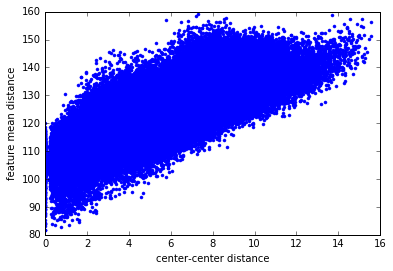

In [16]:
## plot against the distance
iu = np.mask_indices(500,np.triu)
plt.plot(dist[iu],mdist2[iu],marker='.', linewidth=0)
plt.xlabel("center-center distance")
plt.ylabel("feature mean distance")
plt.show()

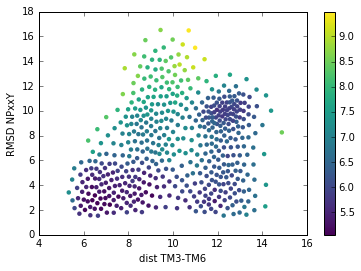

In [28]:
## plot diagonal value (~ variance within each micro)
plt.scatter(scenters[:,0],scenters[:,1],
            linewidths=0,
            #c=np.diag(mdist2),
            c=-np.log(pi),
            cmap='viridis')
plt.xlabel('dist TM3-TM6')
plt.ylabel('RMSD NPxxY')
plt.colorbar()
plt.savefig(filename='fes1.png')
plt.show()

0.0


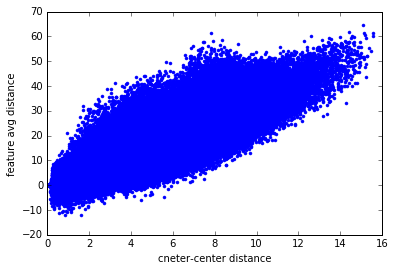

In [26]:
## make constraint traceless (see Dill paper on time-markov models)
logdiag = np.diag(mdist2) - np.diag(mdist2).mean()
mdist3 = mdist2 - 0.5*np.log(np.outer(np.exp(logdiag),np.exp(logdiag))) - np.diag(mdist2).mean()
print(mdist3.trace())
plt.plot(dist[iu],mdist3[iu],marker='.', linewidth=0)
plt.xlabel("cneter-center distance")
plt.ylabel("feature avg distance")
plt.show()

### read MSM model 

In [20]:
model_dist_npxxy = htmd.Model()
model_dist_npxxy.load(basedir + '/reaction_cords/model_dist_npxxy')

In [21]:
tau0 = model_dist_npxxy.lag

In [22]:
P = model_dist_npxxy.msm.P

In [23]:
## retrieve transfer matrix and stat distribution
P = model_dist_npxxy.P
pi = model_dist_npxxy.msm.pi
assert all(abs(P.sum(axis=1)-1)<1e-11)

## calculate rate matrix from P
def my_prob2ratemat(MM,tau0,k=None, verbose=False):
    MMt = np.transpose(MM)
    val,vec = np.linalg.eig(MMt)
    if verbose:
        print(val)
    if not k==None:
        dd = np.diag(np.log(val[0:k])/tau0)
        invz = np.linalg.inv(vec)[0:k,:]
        vec=vec[:,0:k]
    else:
        dd = np.diag(np.log(val)/tau0)
        invz = np.linalg.inv(vec)
    KKt = np.dot(vec,np.dot(dd,invz))
    #KKt[np.abs(KKt)<1.e-8]=0
    val1,vec1 = np.linalg.eig(KKt)
    if verbose:
        print(np.exp(val1*tau0))

    return np.transpose(KKt)

RateMSM = my_prob2ratemat(P,k=30,tau0=tau0,verbose=False)


def my_ratemat2prob(KK,tau0,verbose=False):
    KKt = np.transpose(KK)
    val,vec = np.linalg.eig(KKt)
    if verbose:
        print("eigvals of ratemat")
        print(val)
    dd = np.diag(np.exp(val*tau0))
    invz = np.linalg.inv(vec)
    MMt = np.dot(vec,np.dot(dd,invz))
    #KKt[np.abs(KKt)<1.e-8]=0
    val1,vec1 = np.linalg.eig(MMt)
    if verbose:
        print("log eigvals of prob")
        print(np.log(val1)/tau0)
        plt.plot(val,val,c='red')
        plt.plot(val,np.log(val1)/tau0,'o-')
        
        plt.show()
        
    return np.transpose(MMt)



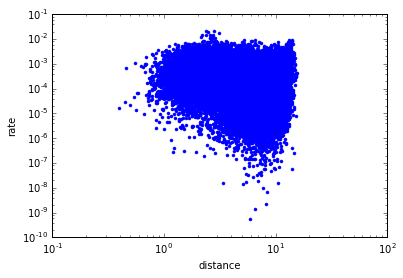

In [24]:

plt.plot(dist[iu],RateMSM[iu],marker='.', linewidth=0)
plt.loglog()
plt.xlabel("distance")
plt.ylabel("rate")
#plt.ylim((1e-4,1))
plt.show()


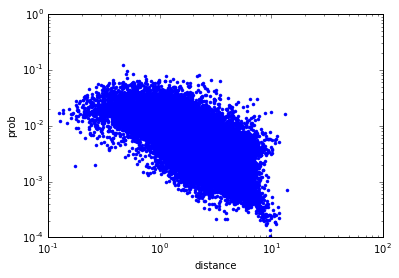

In [25]:
plt.plot(dist[iu],P[iu],marker='.', linewidth=0)
plt.loglog()
plt.xlabel("distance")
plt.ylabel("prob")
plt.ylim((1e-4,1))
plt.show()


In [29]:
def mask_and_norm_diag(K,mask,diag=None,verbose=False):
    """
    masks K removing edges with probabilty below a given threshold, 
    and normalises diagonal so that sum_j kij = -kii (if diag==None),
    and otherwise so that the diagonal is diag
    """
    dims = 1.*mask.sum()/(mask.shape[0]*mask.shape[1])
    if verbose:
        print("masked away fraction %f" % dims)
        print("kept fraction %f" % (1.-dims))
    
    Km = np.copy(K)
    np.fill_diagonal(Km,0)
    Km[mask]=0
    assert all(np.diag(Km)==0)
    if diag==None:
        new_diag = -1.*Km.sum(axis=1)
        np.fill_diagonal(Km,new_diag)
        if not all(abs(Km.sum(axis=1))<1e-11):
            print("Warning >>> ")
            print( abs(Km.sum(axis=1)).max())
    else:
        np.fill_diagonal(Km,diag)
    return Km

In [33]:
def exp_mat(k,mudt,p):
    """
    average of matrix exponential
    """
    t0 = scipy.linalg.expm(mudt*k)
    t1 = np.exp(0.5*np.log(t0) + 0.5*np.log(p))
    return t1

## MaxCal

###  with no information

In [30]:
## MaxCal with no contratints (only <N>)
K = np.sqrt(np.outer(1/pi,pi))
E = dist>5
Km = mask_and_norm_diag(K,E,verbose=True)

masked away fraction 0.492008
kept fraction 0.507992


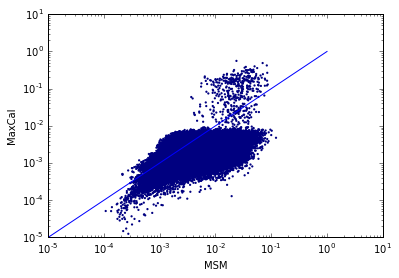

In [31]:
T =  scipy.linalg.expm(0.01*Km)
assert all(abs(T.sum(axis=1)-1)<1e-11)

cols=1*(P.reshape((500*500,)) < 1e-14)

plt.scatter(P.reshape((500*500,)),
         T.reshape((500*500,)),
         marker='.', c=cols,
         linewidth=0)
plt.loglog()
plt.xlabel("MSM")
plt.ylabel("MaxCal")
plt.plot([1e-5,1],[1e-5,1])
plt.show()

###  with distance

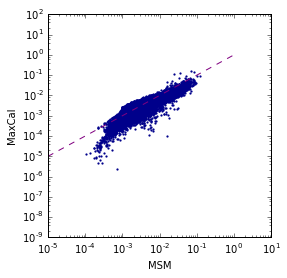

In [38]:
gamma = 2.
mudt = 0.1
W = mask_and_norm_diag(np.exp(-gamma*dist),E, diag = 0)
Delta = W/(mudt)
K = np.sqrt(np.outer(1/pi,pi))*Delta 
Km = mask_and_norm_diag(K,E)

T =  scipy.linalg.expm(mudt*Km)
assert all(abs(T.sum(axis=1)-1)<1e-11)
cols=1*(P.reshape((500*500,)) < 1e-14)
T= exp_mat(Km,mudt,P)

plt.figure(figsize=(4,4))
plt.scatter(
    P[iu],T[iu],
         marker='.',
         linewidth=0,color='darkblue')
plt.loglog()
plt.xlabel("MSM")
plt.ylabel("MaxCal")
plt.ylim([1e-9,1e2])
plt.plot([1e-5,1],[1e-5,1],linestyle='--',color='purple')
plt.savefig(filename='comparison1.png')
plt.show()

In [33]:
def fitme(gamma,mudt):
    #gamma = 1.6
    #mudt = 0.1
    W = mask_and_norm_diag(np.exp(-gamma*dist),E, diag = 0)
    Delta = W/(mudt)
    K = np.sqrt(np.outer(1/pi,pi))*Delta 
    Km = mask_and_norm_diag(K,E)
    T =  scipy.linalg.expm(mudt*Km)
    return np.sum((T-P)**2)
    

Warning >>> 
1.45519152284e-11
Warning >>> 
1.09139364213e-11


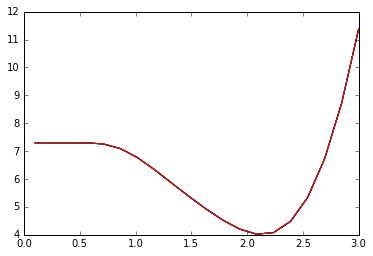

In [34]:
for mudt in np.linspace(0.01,3.0,10):
    gammas=np.linspace(0.1,3,20)
    r1=[fitme(gamma,mudt) for gamma in gammas]
    plt.plot(gammas,r1,label=mudt)
plt.show()

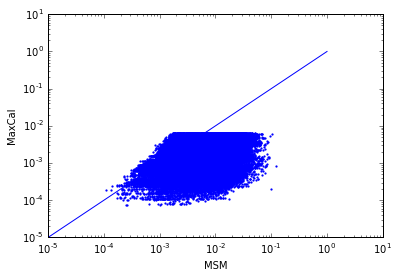

In [625]:
gamma = .3
mudt = 1
W = mask_and_norm_diag(np.exp(-gamma*mdist3),E, diag = 0)
Delta = W/(mudt)
K = np.sqrt(np.outer(1/pi,pi))*Delta
Km = mask_and_norm_diag(K,E)

T =  scipy.linalg.expm(mudt*Km)
assert all(abs(T.sum(axis=1)-1)<1e-11)


plt.scatter((P.reshape((500*500,1))),
         (T.reshape((500*500,1))),
         marker='.',
         linewidth=0)
plt.loglog()
plt.xlabel("MSM")
plt.ylabel("MaxCal")
plt.plot([1e-5,1],[1e-5,1])
plt.show()

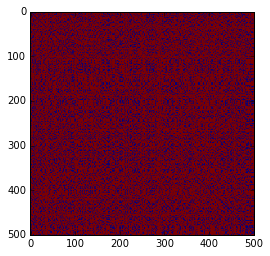

In [386]:
ch = np.zeros_like(P)
ch[np.where(P < 1e-8)]=1
plt.imshow(ch)
plt.show()